In [1]:
import warnings
import pylab
import operator
import pandas as pd
import numpy as np
import tldextract

import math
import matplotlib
import matplotlib.pyplot as plt

from sklearn import metrics
from sklearn.cross_validation import cross_val_score
from sklearn.cross_validation import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix

from collections import Counter

/Users/Shawn/anaconda/lib/python3.6/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
import IPython.core.display as di
di.display_html('<script>jQuery(function() {if (jQuery("body.notebook_app").length == 0) { jQuery(".input_area").toggle(); jQuery(".prompt").toggle();}});</script>', raw=True)

pd.options.mode.chained_assignment = None

## Import data

In [3]:
pylab.rcParams['figure.figsize'] = (14.0, 5.0)
pylab.rcParams['axes.grid'] = True

warnings.filterwarnings("ignore", category = DeprecationWarning)

In [4]:
alexa_dataframe = pd.read_csv('top-1m.csv', names=['rank','uri'], 
                              header=None, encoding='utf-8')
alexa_dataframe.head()

def domain_extract(uri):
    ext = tldextract.extract(uri)
    if (not ext.suffix):
        return np.nan
    else:
        return ext.domain

alexa_dataframe['domain'] = [ domain_extract(uri) for uri in alexa_dataframe['uri']]
del alexa_dataframe['rank']
del alexa_dataframe['uri']


In [6]:
# It's possible we have NaNs from blanklines or whatever
alexa_dataframe = alexa_dataframe.dropna()
alexa_dataframe = alexa_dataframe.drop_duplicates()  # remove duplicates

# Set the class
alexa_dataframe['class'] = 'legit'
print(alexa_dataframe.head())

# Shuffle the data (important for training/testing)
alexa_dataframe = alexa_dataframe.reindex(np.random.permutation(alexa_dataframe.index))
alexa_total = alexa_dataframe.shape[0]
print('Number of total Alexa domains %d' % alexa_total)

# Hold out 10%
hold_out_alexa = alexa_dataframe[int(alexa_total*.9):]
alexa_dataframe = alexa_dataframe[:int(alexa_total*.9)]

print('Number of Alexa_train domains: %d' % alexa_dataframe.shape[0])
print('Number of Alexa_test domains: %d' % hold_out_alexa.shape[0])

     domain  class
0    google  legit
1   youtube  legit
2  facebook  legit
3     baidu  legit
4     yahoo  legit
Number of total Alexa domains 873037
Number of Alexa_train domains: 785733
Number of Alexa_test domains: 87304


In [9]:
# Read in the DGA domains
dga_dataframe = pd.read_csv('all_dga.txt', names=['raw_domain'], 
                            header=None, encoding='utf-8')

dga_dataframe['domain'] = dga_dataframe.applymap(lambda x: x.split('.')[0].strip().lower())
del dga_dataframe['raw_domain']

print('Original DGA domains %d' % (dga_dataframe.shape[0]))
dga_dataframe = dga_dataframe.dropna()
dga_dataframe = dga_dataframe.drop_duplicates()
dga_total = dga_dataframe.shape[0]
print('Dropna DGA domains %d' % dga_total)

dga_dataframe['class'] = 'dga'
print(dga_dataframe.head())

# Hold out 10%
hold_out_dga = dga_dataframe[int(dga_total*.9):]
dga_dataframe = dga_dataframe[:int(dga_total*.9)]

print('Number of DGA_train domains: %d' % dga_dataframe.shape[0])
print('Number of DGA_test domains: %d' % hold_out_dga.shape[0])


Original DGA domains 801667
Dropna DGA domains 693090
            domain class
0  ofdhiydrrttpblp   dga
1  puciftnfkplcbhp   dga
2  bowjjxxnhkyvygk   dga
3  osvwkptpwqyiqen   dga
4  cpmjpnwdgbxyyql   dga
Number of DGA_train domains: 623781
Number of DGA_test domains: 69309


In [10]:
# Concatenate the domains in a big file!
all_domains = pd.concat([alexa_dataframe, dga_dataframe], ignore_index = True)
print('Number of all_train domains: %d' % all_domains.shape[0])
all_domains.head()

Number of all_train domains: 1409514


,domain,class
0,mobile-redirect,legit
1,mpt2017,legit
2,polymaps,legit
3,znajdzksiege,legit
4,youtubeserial,legit


> 輸入好的URL以及惡意的URL，再做合併，其中也發現兩者的數量差異並不大。

## Visualization of Length and Entropy

In [11]:
def entropy(s):
    p, lns = Counter(s), float(len(s))
    return -sum( count/lns * math.log(count/lns, 2) for count in p.values())

In [13]:
all_domains['entropy'] = [entropy(x) for x in all_domains['domain']]
all_domains['length'] = [len(x) for x in all_domains['domain']]
# all_domains = all_domains[all_domains['length'] > 6]
all_domains.columns = ['domain', 'label', 'entropy', 'length']

print(all_domains.head())

            domain  label   entropy  length
0  mobile-redirect  legit  3.323231      15
1          mpt2017  legit  2.807355       7
2         polymaps  legit  2.750000       8
3     znajdzksiege  legit  3.251629      12
4    youtubeserial  legit  3.392747      13


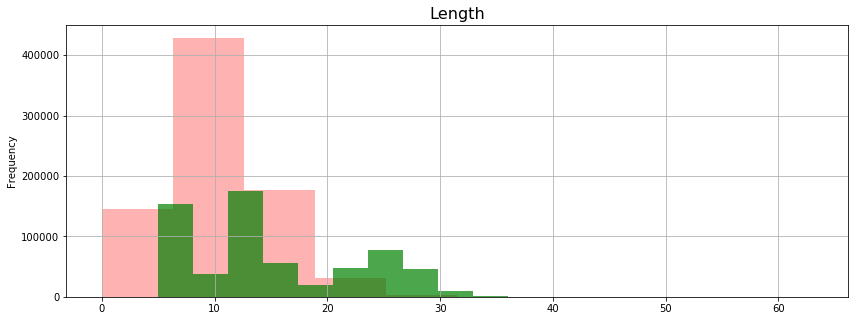

In [19]:
### plot by length
all_domains[all_domains.label == "legit"].length.plot.hist(alpha = 0.3, color='r')
all_domains[all_domains.label == "dga"].length.plot.hist(alpha = 0.7, color='g')

plt.title('Length', fontsize = 16)
plt.show() 

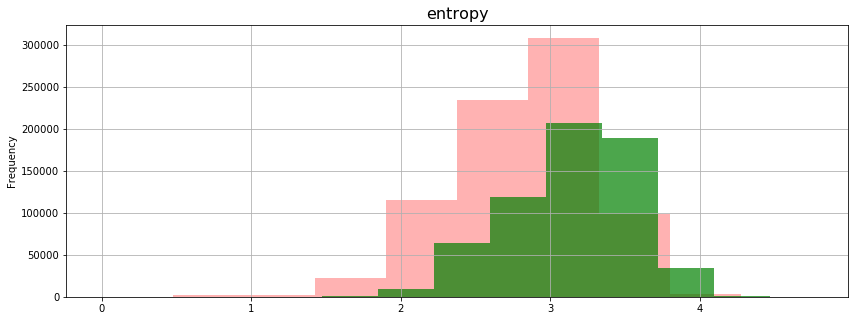

In [20]:
### plot by entropy
all_domains[all_domains.label == "legit"].entropy.plot.hist(alpha = 0.3, color='r')
all_domains[all_domains.label == "dga"].entropy.plot.hist(alpha = 0.7, color='g')

plt.title('entropy', fontsize = 16)
plt.show()

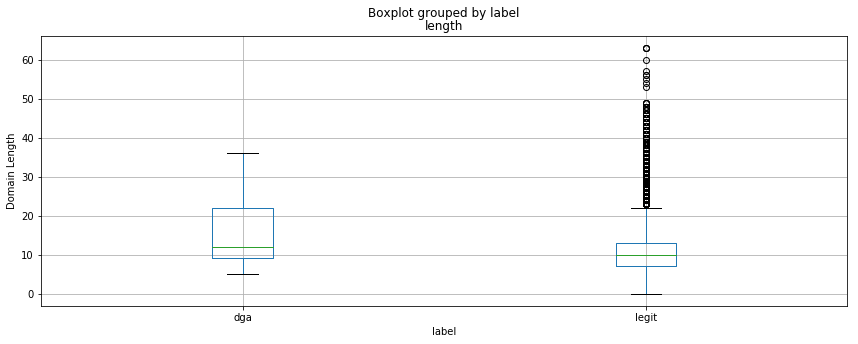

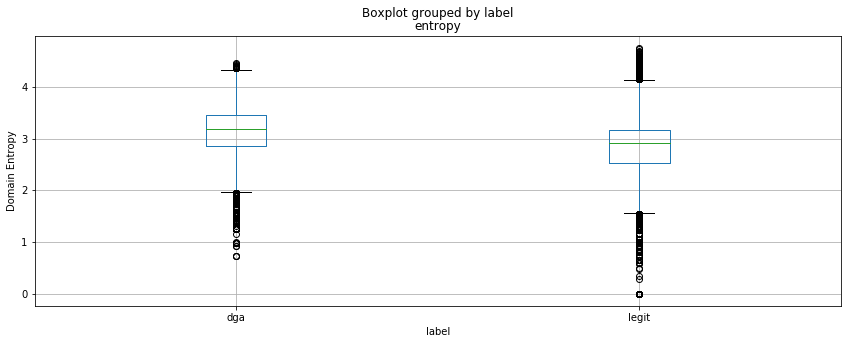

In [21]:
all_domains.boxplot('length','label')
pylab.ylabel('Domain Length')
all_domains.boxplot('entropy','label')
pylab.ylabel('Domain Entropy')
plt.show()

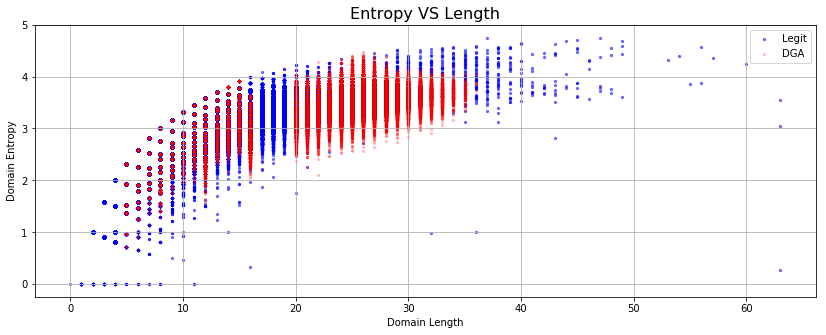

In [22]:
#all_domains = all_domains[all_domains["length"] < 40]
cond = all_domains['label'] == 'dga'
dga = all_domains[cond]
alexa = all_domains[~cond]

plt.scatter(alexa['length'], alexa['entropy'], s = 5, c = 'b', label='Legit', alpha=.5)
plt.scatter(dga['length'], dga['entropy'], s = 5, c = 'r', label='DGA', alpha=.2)

plt.legend()
pylab.xlabel('Domain Length')
pylab.ylabel('Domain Entropy')
plt.title('Entropy VS Length', fontsize = 16)
plt.show()

> 由上面的圖片，其實可以看出length和entropy已經可以大概分出好壞的URL

## Randomforest in Length and Entropy 

In [25]:
X = all_domains.as_matrix(['length', 'entropy'])
y = np.array(all_domains['label'].tolist())
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
print("Shape of training dataset", X_train.shape)
print("Shape of testing dataset", X_test.shape)

Shape of training dataset (1127611, 2)
Shape of testing dataset (281903, 2)


In [29]:
def training(model):
    scores = cross_val_score(model, X_train, y_train, cv = 5, n_jobs=4)
    print("Cross Validation Score")
    print(scores)

In [30]:
from sklearn.ensemble import RandomForestClassifier

rfc = RandomForestClassifier(n_estimators = 20)
training(rfc)

Cross Validation Score
[ 0.774666    0.77384125  0.77490544  0.7739368   0.77538234]


Confusion Matrix Stats
legit/legit: 76.49% (120474/157510)
legit/dga: 23.51% (37036/157510)
dga/legit: 21.07% (26209/124393)
dga/dga: 78.93% (98184/124393)


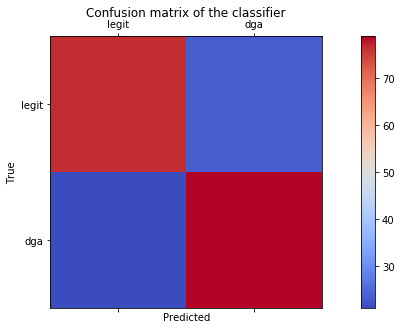

In [34]:
rfc.fit(X_train, y_train)
y_pred = rfc.predict(X_test)

labels = ['legit', 'dga']
cm = confusion_matrix(y_test, y_pred, labels)

def plot_cm(cm, labels):
    
    # Compute percentanges
    percent = (cm*100.0)/np.array(np.matrix(cm.sum(axis=1)).T)  
    # Derp, I'm sure there's a better way
    
    print('Confusion Matrix Stats')
    for i, label_i in enumerate(labels):
        for j, label_j in enumerate(labels):
            print("%s/%s: %.2f%% (%d/%d)" % (label_i, label_j, (percent[i][j]), cm[i][j], cm[i].sum()))

    # Show confusion matrix
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.grid(b=False)
    cax = ax.matshow(percent, cmap='coolwarm')
    pylab.title('Confusion matrix of the classifier')
    fig.colorbar(cax)
    ax.set_xticklabels([''] + labels)
    ax.set_yticklabels([''] + labels)
    pylab.xlabel('Predicted')
    pylab.ylabel('True')
    pylab.show()

plot_cm(cm, labels)

In [35]:
accuracy_score(y_test, y_pred)

0.77564978024355891

## N-Grams_CountVectorizer

In [47]:
from sklearn.feature_extraction.text import CountVectorizer

alexa_vc = CountVectorizer(analyzer='char', ngram_range=(3,5), min_df=1e-4, max_df=1.0)

### 轉換矩陣(藉由資料本身)
counts_matrix = alexa_vc.fit_transform(alexa_dataframe['domain'])
alexa_counts = np.log10(counts_matrix.sum(axis=0).getA1())
ngrams_list = alexa_vc.get_feature_names()

In [48]:
_sorted_ngrams = sorted(zip(ngrams_list, alexa_counts), 
                        key=operator.itemgetter(1), reverse=True)

print('Alexa NGrams: %d' % len(_sorted_ngrams))
for ngram, count in _sorted_ngrams[:10]:
    print(ngram, count)

Alexa NGrams: 27571
ing 4.41980710517
ine 4.3217433782
ion 4.27671449463
ent 4.26796915869
ter 4.26418007504
lin 4.26073901991
the 4.18890037318
and 4.18627810345
por 4.16773075171
ers 4.15845296069


In [49]:
### dictionary words
word_dataframe = pd.read_csv('words.txt', names=['word'], header=None, 
                             dtype={'word': np.str}, encoding='utf-8')
#print word_dataframe.head()

### Cleanup words from dictionary
word_dataframe = word_dataframe[word_dataframe['word'].map(lambda x: str(x).isalpha())]
word_dataframe = word_dataframe.applymap(lambda x: str(x).strip().lower())
word_dataframe = word_dataframe.dropna()
word_dataframe = word_dataframe.drop_duplicates()
#print word_dataframe.head()

In [50]:
dict_vc = CountVectorizer(analyzer='char', ngram_range=(3,5), min_df=1e-5, max_df=1.0)

### 轉換矩陣(藉由外部字典)
counts_matrix = dict_vc.fit_transform(word_dataframe['word'])
dict_counts = np.log10(counts_matrix.sum(axis=0).getA1())
ngrams_list = dict_vc.get_feature_names()

In [51]:
_sorted_ngrams = sorted(zip(ngrams_list, dict_counts), key = operator.itemgetter(1), reverse = True)
print('Word NGrams: %d' % len(_sorted_ngrams))

for ngram, count in _sorted_ngrams[:10]:
    print(ngram, count)

Word NGrams: 103894
ing 4.05762807296
ers 3.67182056018
ies 3.58467038446
ion 3.5166675591
ter 3.51613857672
ate 3.50826030551
ess 3.49220145139
ati 3.48784512011
est 3.44793286559
nes 3.44420098886


In [52]:
def ngram_count(domain):
    alexa_match = alexa_counts * alexa_vc.transform([domain]).T  
    dict_match = dict_counts * dict_vc.transform([domain]).T
    print('%s Alexa match:%d Dict match: %d' % (domain, alexa_match, dict_match))

print("Examples :")
ngram_count('argumentiru')
ngram_count('facebook')
ngram_count('1cb8a5f36f')
ngram_count('pterodactylfarts')
ngram_count('ptes9dro-dwacty2lfa5rrts')
ngram_count('beyonce')
ngram_count('bey666on4ce')

Examples :
argumentiru Alexa match:44 Dict match: 39
facebook Alexa match:43 Dict match: 21
1cb8a5f36f Alexa match:0 Dict match: 0
pterodactylfarts Alexa match:54 Dict match: 41
ptes9dro-dwacty2lfa5rrts Alexa match:30 Dict match: 19
beyonce Alexa match:24 Dict match: 12
bey666on4ce Alexa match:4 Dict match: 1


In [53]:
all_domains['alexa_grams']= alexa_counts * alexa_vc.transform(all_domains['domain']).T 
all_domains['word_grams']= dict_counts * dict_vc.transform(all_domains['domain']).T 
all_domains.head()

,domain,label,entropy,length,alexa_grams,word_grams
0,mobile-redirect,legit,3.323231,15,95.104811,45.148256
1,mpt2017,legit,2.807355,7,13.042814,1.995635
2,polymaps,legit,2.750000,8,26.980713,16.206229
3,znajdzksiege,legit,3.251629,12,18.359445,11.154052
4,youtubeserial,legit,3.392747,13,80.081843,42.494959


> 從all_domains跟word_dataframe中，建立一本字典，藉此計算每個URL在這兩本字典裡的分數。

In [54]:
all_domains['diff'] = all_domains['alexa_grams'] - all_domains['word_grams']
all_domains.sort(['diff'], ascending=True).head(5)

/Users/Shawn/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:2: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  from ipykernel import kernelapp as app


,domain,label,entropy,length,alexa_grams,word_grams,diff
577566,unfaithfulness,legit,3.235926,14,46.332319,60.767590,-14.435272
433040,salubriousness,legit,3.093069,14,51.451964,65.495657,-14.043693
627506,overemphasizing,legit,3.640224,15,56.255975,69.414722,-13.158747
988837,repeatedlyrepeateddenounces,dga,3.319521,27,109.019347,121.389243,-12.369896
606261,regretfulness,legit,3.026987,13,44.493986,56.506362,-12.012376


In [58]:
all_domains.sort(['diff'], ascending=False).head(5)

/Users/Shawn/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:1: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  if __name__ == '__main__':


,domain,label,entropy,length,alexa_grams,word_grams,diff
513242,nicememewebsitewebsitewebsitewebsitewebsite,legit,2.820357,43,256.892258,106.926703,149.965556
411989,techcomputingcomputernetworkinginformation,legit,3.776878,42,335.210236,197.642731,137.567505
372762,yidianliangdiansandiansidianwudianliudianqidia...,legit,3.038988,63,323.477942,186.709618,136.768324
232723,int-arch-photogramm-remote-sens-spatial-inf-sci,legit,3.822122,47,234.991786,102.519474,132.472312
382947,network-marketing-online-business,legit,3.775476,33,242.248850,110.382587,131.866263


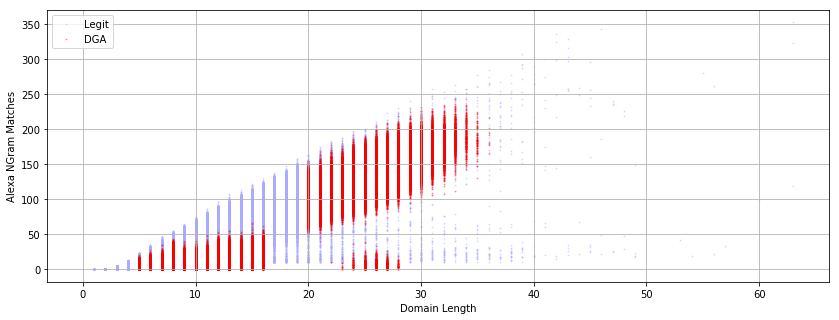

In [59]:
cond = all_domains['label'] == 'dga'
dga = all_domains[cond]
legit = all_domains[~cond]

plt.scatter(legit['length'], legit['alexa_grams'], s = 1, c = '#aaaaff', label='Legit', alpha=.3)
plt.scatter(dga['length'], dga['alexa_grams'], s = 1, c='r', label='DGA', alpha=.3)

plt.legend()
pylab.xlabel('Domain Length')
pylab.ylabel('Alexa NGram Matches')
plt.show()

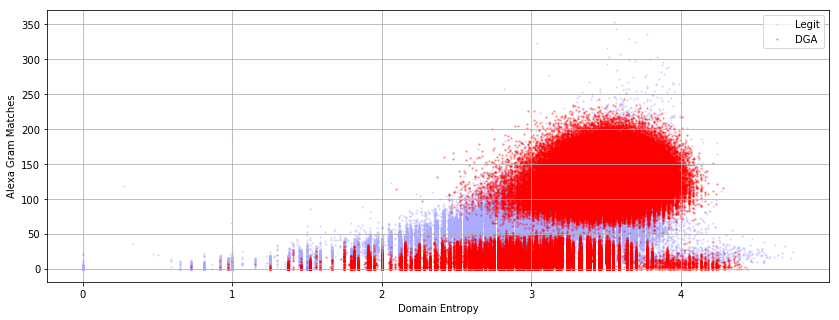

In [60]:
cond = all_domains['label'] == 'dga'
dga = all_domains[cond]
legit = all_domains[~cond]

plt.scatter(legit['entropy'], legit['alexa_grams'],  s=2, c='#aaaaff', label='Legit', alpha=.3)
plt.scatter(dga['entropy'], dga['alexa_grams'], s=2, c='r', label='DGA', alpha=.3)

plt.legend()
pylab.xlabel('Domain Entropy')
pylab.ylabel('Alexa Gram Matches')
plt.show()

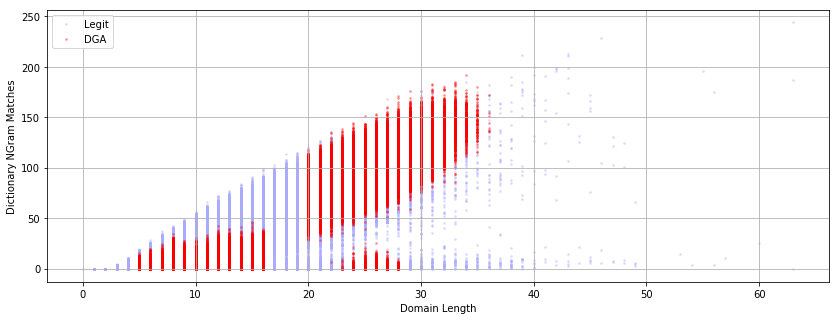

In [61]:
# Lets plot some stuff!
# Here we want to see whether our new 'word_grams' feature can help us differentiate between Legit/DGA
# Note: It doesn't look quite as good as the Alexa_grams but it might generalize better (less overfit).
cond = all_domains['label'] == 'dga'
dga = all_domains[cond]
legit = all_domains[~cond]
plt.scatter(legit['length'], legit['word_grams'],  s=3, c='#aaaaff', label='Legit', alpha=.3)
plt.scatter(dga['length'], dga['word_grams'], s=3, c='r', label='DGA', alpha=.3)
plt.legend()
pylab.xlabel('Domain Length')
pylab.ylabel('Dictionary NGram Matches')
plt.show()


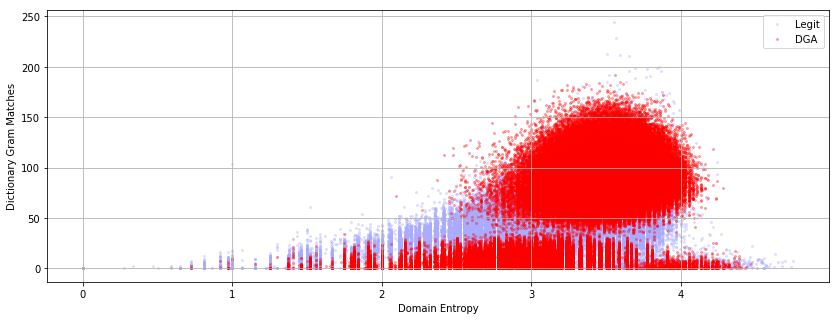

In [62]:
cond = all_domains['label'] == 'dga'
dga = all_domains[cond]
legit = all_domains[~cond]

plt.scatter(legit['entropy'], legit['word_grams'],  s=4, c='#aaaaff', label='Legit', alpha=.3)
plt.scatter(dga['entropy'], dga['word_grams'], s=4, c='r', label='DGA', alpha=.3)

plt.legend()
pylab.xlabel('Domain Entropy')
pylab.ylabel('Dictionary Gram Matches')
plt.show()


> 畫出兩個字點分數與length和entropy之間的散佈圖，發現好壞的點分得更開了。

## Find wired row (max{alexa_grams, word_grams} = 0)

In [63]:
all_domains[all_domains['label']=='legit'].describe()

,entropy,length,alexa_grams,word_grams,diff
count,785733.000000,785733.000000,785733.000000,785733.000000,785733.000000
mean,2.818734,10.343253,43.132314,26.371546,16.760768
std,0.488679,4.297928,30.529034,19.774269,12.870490
min,-0.000000,0.000000,0.000000,0.000000,-14.435272
25%,2.521641,7.000000,20.274195,11.586130,7.065764
50%,2.913977,10.000000,37.756885,22.687438,14.112224
75%,3.169925,13.000000,60.095606,37.065510,23.556634
max,4.750877,63.000000,352.288678,244.102551,149.965556


In [64]:
all_domains[all_domains['label']=='dga'].describe()

,entropy,length,alexa_grams,word_grams,diff
count,623781.000000,623781.000000,623781.000000,623781.000000,623781.000000
mean,3.137749,15.287154,48.423519,34.167221,14.256298
std,0.415918,7.111375,56.217991,41.907318,15.506746
min,0.721928,5.000000,0.000000,0.000000,-12.369896
25%,2.855389,9.000000,7.791865,3.990871,3.157444
50%,3.188722,12.000000,15.874610,9.343116,6.728726
75%,3.455650,22.000000,105.812927,76.622717,25.496027
max,4.469670,36.000000,242.333598,191.766266,89.809850


> 有些資料的分數是0分，是因為字典的選擇而導致。

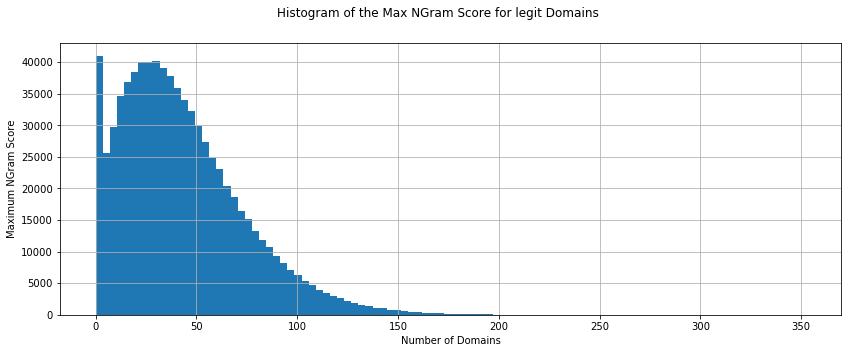

In [65]:
legit = all_domains[(all_domains['label']=='legit')]
max_grams = np.maximum(legit['alexa_grams'],legit['word_grams'])
ax = max_grams.hist(bins=100)

ax.figure.suptitle('Histogram of the Max NGram Score for legit Domains')
pylab.xlabel('Number of Domains')
pylab.ylabel('Maximum NGram Score')
plt.show()

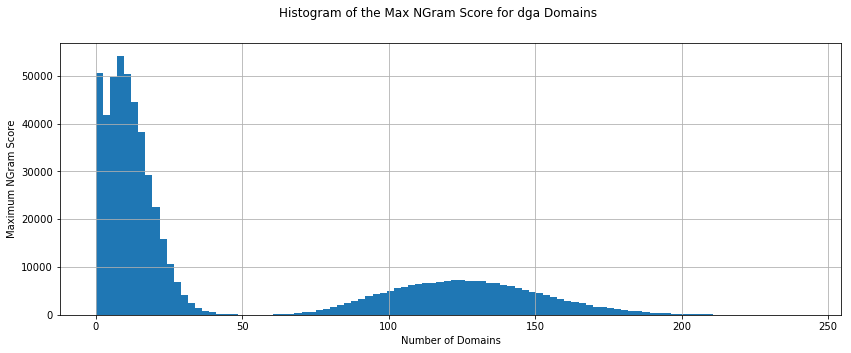

In [66]:
legit = all_domains[(all_domains['label']=='dga')]
max_grams = np.maximum(legit['alexa_grams'],legit['word_grams'])
ax = max_grams.hist(bins=100)
ax.figure.suptitle('Histogram of the Max NGram Score for dga Domains')
pylab.xlabel('Number of Domains')
pylab.ylabel('Maximum NGram Score')
plt.show()

In [68]:
weird_cond = (all_domains['label']=='dga') & (all_domains['word_grams'] == 0) & (all_domains['alexa_grams'] == 0)
weird = all_domains[weird_cond]
print("Number of weird URL", weird.shape[0])

Number of weird URL 18873


In [69]:
# Lets look at which Legit domains are scoring low on both alexa and word gram count
weird_cond = (all_domains['label']=='legit') & (all_domains['word_grams'] == 0) & (all_domains['alexa_grams'] == 0)
weird = all_domains[weird_cond]
print("Number of weird URL", weird.shape[0])

Number of weird URL 19442


In [71]:
all_domains.loc[weird_cond, 'label'] = 'weird'
print(all_domains['label'].value_counts())

all_domains[all_domains['label'] == 'weird'].head()

legit    766291
dga      623781
weird     19442
Name: label, dtype: int64


,domain,label,entropy,length,alexa_grams,word_grams,diff
13,mln,weird,1.584963,3,0.0,0.0,0.0
28,se88,weird,1.500000,4,0.0,0.0,0.0
45,dct56,weird,2.321928,5,0.0,0.0,0.0
232,xywxs,weird,1.921928,5,0.0,0.0,0.0
329,wnzxw,weird,1.921928,5,0.0,0.0,0.0


> 將兩個分數都為0並且為"legit"的資料當作weird。

In [72]:
X = all_domains.as_matrix(['length', 'entropy', 'alexa_grams', 'word_grams'])
y = np.array(all_domains['label'].tolist())

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
print("Shape of training dataset :", X_train.shape)
print("Shape of testing dataset :", X_test.shape)

Shape of training dataset : (1127611, 4)
Shape of testing dataset : (281903, 4)


In [77]:
rfc = RandomForestClassifier(n_estimators=20) 
training(rfc)
rfc.fit(X_train, y_train)
y_pred = rfc.predict(X_test)
print("Accuracy Score :", accuracy_score(y_test, y_pred))

Cross Validation Score
[ 0.93674259  0.93700421  0.93575378  0.93624984  0.93519451]
Accuracy Score : 0.9377197121


Confusion Matrix Stats
legit/legit: 93.96% (143744/152986)
legit/weird: 0.00% (0/152986)
legit/dga: 6.04% (9242/152986)
weird/legit: 0.00% (0/3834)
weird/weird: 83.96% (3219/3834)
weird/dga: 16.04% (615/3834)
dga/legit: 5.90% (7379/125083)
dga/weird: 0.26% (321/125083)
dga/dga: 93.84% (117383/125083)


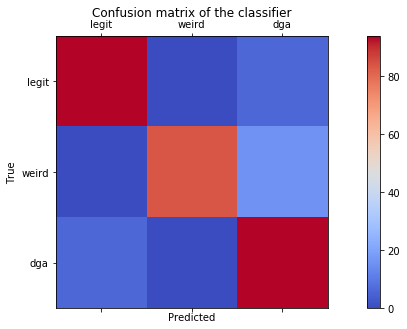

In [78]:
labels = ['legit', 'weird', 'dga']
cm = confusion_matrix(y_test, y_pred, labels)
plot_cm(cm, labels)

### Evaluation: Train by Removing Weird Points

In [81]:
not_weird = all_domains[all_domains['label'] != 'weird']
X = not_weird.as_matrix(['length', 'entropy', 'alexa_grams', 'word_grams'])
y = np.array(not_weird['label'].tolist())

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
rfc.fit(X_train, y_train)
y_pred = rfc.predict(X_test)
print(accuracy_score(y_test, y_pred))

0.939693901408


Confusion Matrix Stats
legit/legit: 93.92% (144197/153531)
legit/dga: 6.08% (9334/153531)
dga/legit: 5.97% (7432/124484)
dga/dga: 94.03% (117052/124484)


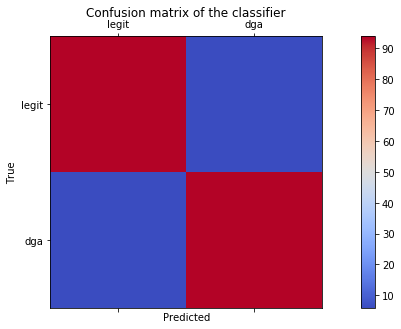

In [82]:
labels = ['legit', 'dga']
cm = confusion_matrix(y_test, y_pred, labels)
plot_cm(cm, labels)
plt.show()

## Testing

In [83]:
rfc.fit(X, y)

hold_out_domains = pd.concat([hold_out_alexa, hold_out_dga], ignore_index=True)
hold_out_domains['length'] = [len(x) for x in hold_out_domains['domain']]
hold_out_domains = hold_out_domains[hold_out_domains['length'] > 6]
hold_out_domains['entropy'] = [entropy(x) for x in hold_out_domains['domain']]
hold_out_domains['alexa_grams']= alexa_counts * alexa_vc.transform(hold_out_domains['domain']).T
hold_out_domains['word_grams']= dict_counts * dict_vc.transform(hold_out_domains['domain']).T

hold_out_domains.head()

,domain,class,length,entropy,alexa_grams,word_grams
0,historicacanada,legit,15,3.106891,96.472491,58.425135
1,hclokomotiv,legit,11,3.027169,40.558370,23.286070
2,filesuploading,legit,14,3.521641,79.655149,49.557758
3,cuttingedge,legit,11,2.913977,45.980752,47.123663
4,dabaoku,legit,7,2.521641,16.391563,6.195904


Confusion Matrix Stats
legit/legit: 93.68% (66689/71190)
legit/dga: 6.32% (4501/71190)
dga/legit: 0.45% (311/69309)
dga/dga: 99.55% (68998/69309)


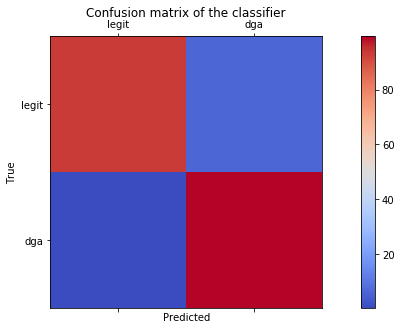

In [84]:
hold_X = hold_out_domains.as_matrix(['length', 'entropy', 'alexa_grams', 'word_grams'])
hold_y = np.array(hold_out_domains['class'].tolist())

hold_y_pred = rfc.predict(hold_X)
hold_out_domains['pred'] = hold_y_pred

labels = ['legit', 'dga']
cm = confusion_matrix(hold_y, hold_y_pred, labels)
plot_cm(cm, labels) 
plt.show()

In [85]:
print("Accuracy Score", accuracy_score(hold_y, hold_y_pred))

Accuracy Score 0.965750645912


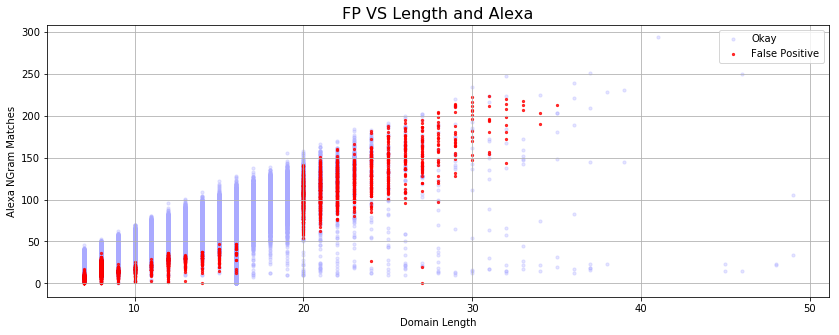

In [96]:
fp_cond = ((hold_out_domains['class'] == 'legit') & (hold_out_domains['pred']=='dga'))
fp = hold_out_domains[fp_cond]
fn_cond = ((hold_out_domains['class'] == 'dba') & (hold_out_domains['pred']=='legit'))
fn = hold_out_domains[fn_cond]
okay = hold_out_domains[hold_out_domains['class'] == hold_out_domains['pred']]

plt.scatter(okay['length'], okay['alexa_grams'], s = 10,  c='#aaaaff', label='Okay', alpha=.3)
plt.scatter(fp['length'], fp['alexa_grams'], s = 5, c='r', label='False Positive', alpha=.8)

plt.title('FP VS Length and Alexa', fontsize = 16)
plt.legend()
pylab.xlabel('Domain Length')
pylab.ylabel('Alexa NGram Matches')
plt.show()

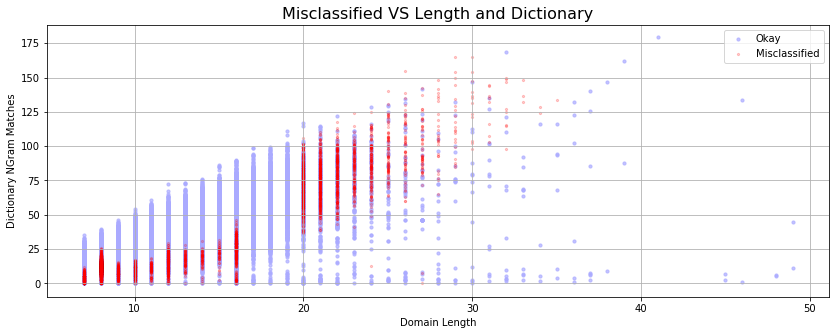

In [95]:
cond = (hold_out_domains['class'] != hold_out_domains['pred'])
misclassified = hold_out_domains[cond]
okay = hold_out_domains[~cond]

plt.scatter(okay['length'], okay['word_grams'], s = 10,  c='#aaaaff', label='Okay', alpha=.7)
plt.scatter(misclassified['length'], misclassified['word_grams'], s = 5, c='r', label='Misclassified', alpha=.2)

plt.title('Misclassified VS Length and Dictionary', fontsize = 16)
plt.legend()
pylab.xlabel('Domain Length')
pylab.ylabel('Dictionary NGram Matches')
plt.show()

In [94]:
def test_it(domain):
    
    _alexa_match = alexa_counts * alexa_vc.transform([domain]).T  # Woot matrix multiply and transpose Woo Hoo!
    _dict_match = dict_counts * dict_vc.transform([domain]).T
    _X = [len(domain), entropy(domain), _alexa_match, _dict_match]
    print('%s : %s' % (domain, rfc.predict(_X)[0]))

test_it('google')
test_it('google88')
test_it('facebook')
test_it('1cb8a5f36f')
test_it('pterodactylfarts')
test_it('ptes9dro-dwacty2lfa5rrts')
test_it('beyonce')
test_it('bey666on4ce')
test_it('supersexy')
test_it('yourmomissohotinthesummertime')
test_it('35-sdf-09jq43r')
test_it('clicksecurity')

google : legit
google88 : legit
facebook : legit
1cb8a5f36f : dga
pterodactylfarts : legit
ptes9dro-dwacty2lfa5rrts : legit
beyonce : legit
bey666on4ce : dga
supersexy : legit
yourmomissohotinthesummertime : dga
35-sdf-09jq43r : dga
clicksecurity : legit


## Try TfidfVectorizer Matrix

In [98]:
not_weird.label = not_weird.label.astype("category").cat.codes
print(not_weird.shape)
not_weird.head()

(1390072, 7)


,domain,label,entropy,length,alexa_grams,word_grams,diff
0,mobile-redirect,1,3.323231,15,95.104811,45.148256,49.956555
1,mpt2017,1,2.807355,7,13.042814,1.995635,11.047179
2,polymaps,1,2.750000,8,26.980713,16.206229,10.774483
3,znajdzksiege,1,3.251629,12,18.359445,11.154052,7.205393
4,youtubeserial,1,3.392747,13,80.081843,42.494959,37.586885


In [100]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(min_df = 0.0, analyzer = "char", decode_error = "ignore", 
                             sublinear_tf = True, ngram_range = (3,5))

X = vectorizer.fit_transform(not_weird['domain'])
y = not_weird["label"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42) 

In [101]:
lgs = LogisticRegression(class_weight='balanced')
lgs.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

In [121]:
def testing(model):
    predicted = model.predict(X_test)

    fpr, tpr, _ = metrics.roc_curve(y_test, (model.predict_proba(X_test)[:, 1]))
    auc = metrics.auc(fpr, tpr)

    print("Accuracy: %f" % model.score(X_test, y_test))  #checking the accuracy
    print("Precision: %f" % metrics.precision_score(y_test, predicted))
    print("Recall: %f" % metrics.recall_score(y_test, predicted))
    print("F1-Score: %f" % metrics.f1_score(y_test, predicted))
    print("AUC: %f" % auc)

In [102]:
predicted = lgs.predict(X_test)

fpr, tpr, _ = metrics.roc_curve(y_test, (lgs.predict_proba(X_test)[:, 1]))
auc = metrics.auc(fpr, tpr)

print("Accuracy: %f" % lgs.score(X_test, y_test))  #checking the accuracy
print("Precision: %f" % metrics.precision_score(y_test, predicted))
print("Recall: %f" % metrics.recall_score(y_test, predicted))
print("F1-Score: %f" % metrics.f1_score(y_test, predicted))
print("AUC: %f" % auc)

Accuracy: 0.950460
Precision: 0.967818
Recall: 0.941247
F1-Score: 0.954347
AUC: 0.989080


### Testing

In [103]:
lgs.fit(X, y)

hold_out_domains.columns = ['domain', 'label', 'length', 'entrop', 'alexa_grams', 'word_grams', 'diff']
hold_out_domains.label = hold_out_domains.label.astype("category").cat.codes

hold_out_X = vectorizer.transform(hold_out_domains['domain'])
hold_out_y = hold_out_domains["label"]

predicted = lgs.predict(hold_out_X)
fpr, tpr, _ = metrics.roc_curve(hold_out_y, (lgs.predict_proba(hold_out_X)[:, 1]))
auc = metrics.auc(fpr, tpr)

print("Accuracy: %f" % lgs.score(hold_out_X, hold_out_y))  #checking the accuracy
print("Precision: %f" % metrics.precision_score(hold_out_y, predicted))
print("Recall: %f" % metrics.recall_score(hold_out_y, predicted))
print("F1-Score: %f" % metrics.f1_score(hold_out_y, predicted))
print("AUC: %f" % auc)

Accuracy: 0.982790
Precision: 0.992298
Recall: 0.973592
F1-Score: 0.982856
AUC: 0.998260


Confusion Matrix Stats
0/0: 99.22% (68771/69309)
0/1: 0.78% (538/69309)
1/0: 2.64% (1880/71190)
1/1: 97.36% (69310/71190)


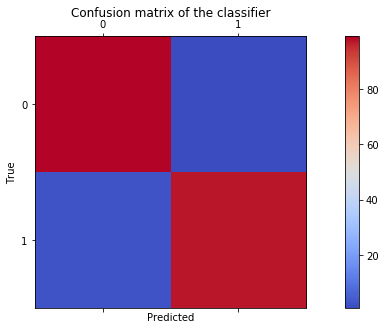

In [111]:
hold_y = np.array(hold_out_domains['label'].tolist())

labels = [0, 1]
cm = confusion_matrix(hold_y, predicted, labels)
plot_cm(cm, labels) 
plt.show()

> 由圖可知用tfidf的矩陣效果不錯

## 試試看用tfidf算分數然後建模

In [117]:
### 計算分數alexa
alexa_vc = TfidfVectorizer(min_df = 0.0, analyzer = "char", decode_error = "ignore", 
                             sublinear_tf = True, ngram_range = (3,5))

counts_matrix = alexa_vc.fit_transform(alexa_dataframe['domain'])
alexa_counts = np.log10(counts_matrix.sum(axis=0).getA1())
ngrams_list = vectorizer.get_feature_names()

_sorted_ngrams = sorted(zip(ngrams_list, alexa_counts), 
                        key=operator.itemgetter(1), reverse=True)
print('Alexa NGrams by tfidf: %d' % len(_sorted_ngrams))

for ngram, count in _sorted_ngrams[:10]:
    print(ngram, count)

### 計算分數word
dict_vc = TfidfVectorizer(min_df = 0.0, analyzer = "char", decode_error = "ignore", 
                             sublinear_tf = True, ngram_range = (3,5))

counts_matrix = dict_vc.fit_transform(word_dataframe['word'])
dict_counts = np.log10(counts_matrix.sum(axis=0).getA1())
ngrams_list = dict_vc.get_feature_names()

_sorted_ngrams = sorted(zip(ngrams_list, dict_counts), key = operator.itemgetter(1), reverse = True)
print('Word NGrams by tfidf: %d' % len(_sorted_ngrams))

for ngram, count in _sorted_ngrams[:10]:
    print(ngram, count)

Alexa NGrams by tfidf: 1321777
dcgrg 3.38127797667
dcdtn 3.32709225228
dzinu 3.28620543483
gstfr 3.27466004395
bturi 3.2674105443
ddgkd 3.2512678204
fmhdi 3.2209048248
agdhc 3.20811328675
gtral 3.19904795541
gwvmi 3.19855081345
Word NGrams by tfidf: 124321
ing 3.05718946943
ers 2.79812994147
ies 2.69257038595
ter 2.67282993412
ate 2.65534979886
est 2.61715991784
ion 2.61688984251
ess 2.60097943545
ati 2.59600725369
tin 2.59595561252


In [118]:
not_weird['tfidf_grams']= alexa_counts * alexa_vc.transform(not_weird['domain']).T 
not_weird['tfidf_grams_word']= dict_counts * dict_vc.transform(not_weird['domain']).T 
not_weird['diff1'] = not_weird['tfidf_grams'] - not_weird['tfidf_grams_word']
not_weird.head()

,domain,label,entropy,length,alexa_grams,word_grams,diff,tfidf_grams,diff1,tfidf_grams_word
0,mobile-redirect,1,3.323231,15,95.104811,45.148256,49.956555,10.974845,5.548340,5.426506
1,mpt2017,1,2.807355,7,13.042814,1.995635,11.047179,2.453686,1.090541,1.363145
2,polymaps,1,2.750000,8,26.980713,16.206229,10.774483,4.985336,2.681848,2.303488
3,znajdzksiege,1,3.251629,12,18.359445,11.154052,7.205393,2.544686,0.759563,1.785123
4,youtubeserial,1,3.392747,13,80.081843,42.494959,37.586885,10.571684,5.602409,4.969275


In [119]:
X = not_weird[['tfidf_grams', "diff1", "tfidf_grams_word", 'entropy','length']]
y = not_weird[['label']]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42) 
print("Shape of training dataset :", X_train.shape)
print("Shape of testing dataset :", X_test.shape)

Shape of training dataset : (1112057, 5)
Shape of testing dataset : (278015, 5)


In [125]:
lgs = LogisticRegression(class_weight='balanced')
lgs.fit(X_train, y_train)

predicted = lgs.predict(X_test)

fpr, tpr, _ = metrics.roc_curve(y_test, (lgs.predict_proba(X_test)[:, 1]))
auc = metrics.auc(fpr, tpr)

print("Accuracy: %f" % lgs.score(X_test, y_test))  #checking the accuracy
print("Precision: %f" % metrics.precision_score(y_test, predicted))
print("Recall: %f" % metrics.recall_score(y_test, predicted))
print("F1-Score: %f" % metrics.f1_score(y_test, predicted))
print("AUC: %f" % auc)

/Users/Shawn/anaconda/lib/python3.6/site-packages/sklearn/utils/validation.py:526: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Accuracy: 0.856252
Precision: 0.867320
Recall: 0.872117
F1-Score: 0.869712
AUC: 0.931507
